In [1]:
#import deeplake
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import torch
import torchvision
from sklearn.preprocessing import normalize
from google.colab import drive
import numpy as np

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


%load_ext autoreload
%autoreload 2

In [2]:
# Define preprocessing functions
def preprocess(features):
    image = features['image']
    label = features['label']

    # Resize images to 256x256
    image = tf.image.resize(image, (256, 256))

    # Normalize the image to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Data augmentation
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_flip_up_down(image)    # Random vertical flip
    # image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness
    # image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Random contrast

    return image, label


def filter_fn(image, label):
    feature_counts = tf.reduce_sum(tf.cast(image >= 1e-10, tf.float32))
    # 95% of pixels should be above 1e-10
    sufficient_features_within_range = feature_counts > (256 * 256 * 3 * 0.99)
    return sufficient_features_within_range

In [3]:
def plot_accuracy(history):
    plt.figure(figsize=(5, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.legend(loc='upper left')
    #plt.yticks(np.arange(0, 1.05, 0.05))
    plt.grid(True)
    plt.show()

def plot_loss(history):
    plt.figure(figsize=(5, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

def count_elements(ds):
    count = 0
    for _ in ds:
        count += 1
    return count


if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Good to go!


In [4]:
# Step 1: Mount Google Drive
drive.mount("/content/drive", force_remount=True)

# GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive')
# print(os.listdir(GOOGLE_DRIVE_PATH))
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'HealthML'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
data_dir = GOOGLE_DRIVE_PATH
dataset_name = 'food101'



Mounted at /content/drive
['testData.ipynb']


In [ ]:
# Get the dataset builder
builder = tfds.builder('food101', data_dir=data_dir)

# Download and prepare the dataset if not already done
builder.download_and_prepare()

# Load the dataset with info
ds_train = builder.as_dataset(split='train')
ds_val = builder.as_dataset(split='validation')
ds_info = builder.info

# Print dataset information
print(ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
# Step 2: Load the dataset
# Check if the dataset is already downloaded in the specified `data_dir`
# Try to load the dataset from the specified directory

try:
    ds_train, ds_train_info = tfds.load(dataset_name, split='train', with_info=True, download=False, data_dir=data_dir)
    print("Training dataset loaded successfully from", data_dir)
except AssertionError as error:
    # If the dataset is not found, download it
    print("Training dataset not found in the specified directory. Downloading...")
    ds_train, ds_train_info = tfds.load(dataset_name, split='train', with_info=True, download=True, data_dir=data_dir)
    print("Training download completed.")

try:
    ds_val, ds_val_info = tfds.load(dataset_name, split='validation', with_info=True, download=False, data_dir=data_dir)
    print("Validation dataset loaded successfully from", data_dir)
except AssertionError as error:
    # If the dataset is not found, download it
    print("Validation dataset not found in the specified directory. Downloading...")
    ds_val, ds_val_info = tfds.load(dataset_name, split='validation', with_info=True, download=True, data_dir=data_dir)
    print("Validation download completed.")


In [ ]:
# print(os.listdir(GOOGLE_DRIVE_PATH))
# path2 = os.path.join('drive', 'My Drive', 'Food ML')
# print(os.listdir(path2))

ds_val, ds_val_info = tfds.load(dataset_name, split='validation', with_info=True, download=False, data_dir=data_dir)


In [ ]:
label_names = ds_val_info.features['label'].names

for example in ds_val.take(5):
  image, label = example["image"], example["label"]
  label_name = label_names[label.numpy()]

  # Display the image
  plt.figure(figsize=(8, 8))
  plt.imshow(image.numpy())
  plt.title(label_name)
  plt.axis('off')  # Hide the axis
  plt.show()

NameError: name 'ds_val_info' is not defined

In [ ]:
# The `ds_info` object contains useful information about the dataset
print(ds_info.features)
print(ds_info.splits)
ds_train_size = ds_info.splits['train'].num_examples
ds_val_size = ds_info.splits['validation'].num_examples

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})
{'train': <SplitInfo num_examples=75750, num_shards=32>, 'validation': <SplitInfo num_examples=25250, num_shards=16>}


In [ ]:
#ds_subset = ds.take(25000)
subset_factor = .60
ds_subset_size = [int(ds_train_size * subset_factor), int(ds_val_size * subset_factor)]

# Apply preprocessing and filtering
ds_train_subset = ds_train.shuffle(buffer_size=10000).take(ds_subset_size[0]).map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val_subset = ds_val.shuffle(buffer_size=10000).take(ds_subset_size[1]).map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_subset = ds_subset.map(standardize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train_subset = ds_train_subset.filter(filter_fn)
ds_val_subset = ds_val_subset.filter(filter_fn)


# Print the size of the dataset
train_dataset_size = count_elements(ds_train_subset)
val_dataset_size = count_elements(ds_val_subset)

print("No error here")

No error here


In [ ]:
print(f'The training dataset contains {train_dataset_size} elements after preprocessing and filtering.')
print(f'The validation dataset contains {val_dataset_size} elements after preprocessing and filtering.')

The training dataset contains 36202 elements after preprocessing and filtering.
The validation dataset contains 12370 elements after preprocessing and filtering.


In [ ]:
# ds_train_subset = ds_train_subset.cache()
# ds_train_subset = ds_train_subset.shuffle(buffer_size=10000)
# ds_train_subset = ds_train_subset.batch(32)
# ds_train_subset = ds_train_subset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

ds_train_subset = ds_train_subset.cache().shuffle(buffer_size=10000).batch(36)
ds_train_subset = ds_train_subset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds_val_subset = ds_val_subset.cache().shuffle(buffer_size=10000).batch(36)
ds_val_subset = ds_val_subset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
ds_train_subset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    #layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(101, activation='softmax')  # Adjust the number of classes as needed
])

optimizer = Adam()  # Adjust the learning rate
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 batch_normalization_21 (Ba  (None, 254, 254, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 127, 127, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 125, 125, 64)      36928     
                                                                 
 dropout_13 (Dropout)        (None, 125, 125, 64)      0         
                                                                 
 batch_normalization_22 (Ba  (None, 125, 125, 64)     

In [ ]:
history = model.fit(ds_train_subset, epochs=12)  # Train for 10 epochs #validation_data=ds_val_subset

Epoch 1/10
1005/1005 [==============================] - 162s 157ms/step - loss: 53.0808 - accuracy: 0.0278 - val_loss: 29.8860 - val_accuracy: 0.0088
Epoch 2/10
1005/1005 [==============================] - 156s 155ms/step - loss: 4.5099 - accuracy: 0.0885 - val_loss: 51.9730 - val_accuracy: 0.0086
Epoch 3/10
1005/1005 [==============================] - 156s 155ms/step - loss: 4.1489 - accuracy: 0.1471 - val_loss: 22.2550 - val_accuracy: 0.0139
Epoch 4/10
1005/1005 [==============================] - 156s 155ms/step - loss: 3.3553 - accuracy: 0.2908 - val_loss: 18.1256 - val_accuracy: 0.0156
Epoch 5/10
1005/1005 [==============================] - 156s 155ms/step - loss: 1.9719 - accuracy: 0.5486 - val_loss: 22.1636 - val_accuracy: 0.0130
Epoch 6/10
1005/1005 [==============================] - 156s 155ms/step - loss: 1.0423 - accuracy: 0.7392 - val_loss: 18.7558 - val_accuracy: 0.0140
Epoch 7/10
1005/1005 [==============================] - 156s 155ms/step - loss: 0.6242 - accuracy: 0.8373

In [ ]:
#Save the model
SAVE_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'tfmodel1')
model.save(GOOGLE_DRIVE_PATH)

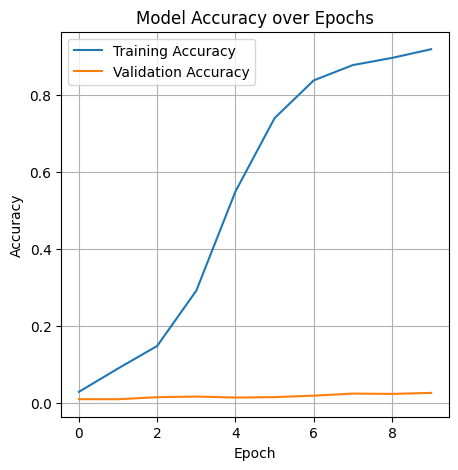

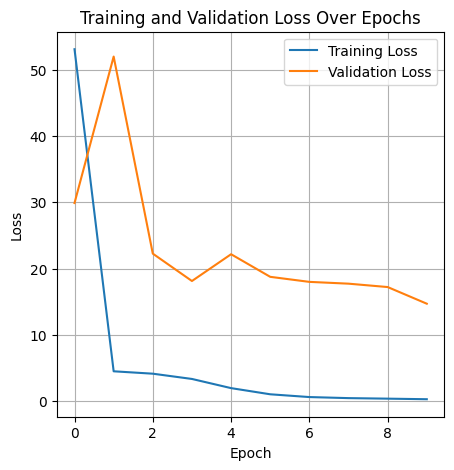

In [ ]:
plot_accuracy(history)
plot_loss(history)